In [1]:
"""

Date: 12 Feb 2020

Python version:      3.7
Tensorboard version: 1.14.0
PyTorch version:     1.2.0

@author: Maksim Lavrov

CIFAR10

Only single flexilayer
No max pooling following

Reverse Threshold


"""

# imports
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# datasets
trainset = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=False,
    transform=transform)

#create a dataset subset to reduce training time

sampler_train = list(range(0, len(trainset), 5000))
sampler_test = list(range(0, len(testset), 5000))
#trainset_samp = torch.utils.data.Subset(trainset, sampler_train)
#testset_samp = torch.utils.data.Subset(testset, sampler_test)

#set size of batch and learning rate
batch_size=4
lr=0.001

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
class FlexiLayer(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros'):
        kernel_size = kernel_size
        stride = stride
        padding = padding
        dilation = dilation
        super(FlexiLayer, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            groups, bias, padding_mode)
        
        
        self.threshold1 = nn.parameter.Parameter(torch.randn((4, 12, 28, 28)), requires_grad=True)
        self.memorized = self.threshold1.clone()
        self.memorized_1loop = []
        self.memorized_1pixel = []
        self.thresh_max = []
        self.thresh_min = []
        self.thresh_mean = []
            
    def forward(self, t):
        
        t_1 = F.relu(F.conv2d(t, self.weight)) # get convolution result
        t_2 = F.avg_pool2d(t, kernel_size=5, stride=1) # get avg result with the same kernel size
        t_2 = torch.cat((t_2, t_2, t_2, t_2), 1)
        m = nn.Sigmoid()
        condmax = torch.sub(self.threshold1, t_2)
        condconv = torch.sub(self.threshold1, t_2)
        t_2 = m(condmax*50)*t_2 # 
        t_1 = m(condconv*(-50))*t_1 # 
        t = torch.add(t_2, t_1)
        #t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        return t

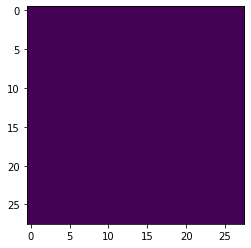

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flex1 = FlexiLayer(in_channels=3, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features= 3 * 56 * 56, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10) # number of classes

    def forward(self, t):
        
        # (2) Flexible layer
        t = self.flex1(t)
        
        # (4) hidden linear layer
        t = F.relu(self.fc1(t.reshape(-1, 3 * 56 * 56)))
        # (5) hidden linear layer
        t = F.relu(self.fc2(t))
        # (6) output layer
        t = self.out(t)
        
        return t

net = Net()
memorized = net.flex1.memorized
#before training
imgplot = plt.imshow(net.flex1.threshold1.detach().numpy()[1,1,:] - memorized.detach().numpy()[1,1,:])

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

In [5]:
# helper functions

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

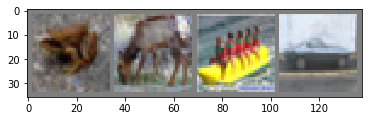

 frog  deer  ship   car


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
#from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter(comment=f'2_Bigdataset_test1-Optimisation-Xavier  batch_size={batch_size} lr={lr}')

<Figure size 432x288 with 0 Axes>

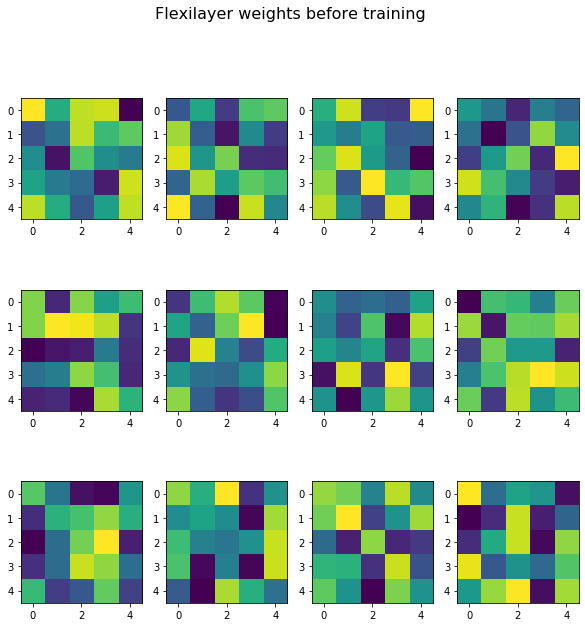

In [8]:
# plot the flex weights before training

fig = plt.figure()
plt.figure(figsize=(10,10))
plt.suptitle('Flexilayer weights before training', fontsize = 16)
for idx, filt  in enumerate(net.flex1.weight.detach().numpy()[:,0,:,:]):
    plt.subplot(3,4, idx + 1)
    plt.imshow(net.flex1.weight.detach().numpy()[idx,0,:,:]) # , cmap="gray"

    
fig.show()

epoch: 0 loss: 81234.98375171423
epoch: 1 loss: 68021.76240703464
epoch: 2 loss: 62321.70116059482
epoch: 3 loss: 58504.356401219964
epoch: 4 loss: 54546.926831550896
epoch: 5 loss: 51202.806811242364
epoch: 6 loss: 48160.46235212404
epoch: 7 loss: 45492.73147327732
epoch: 8 loss: 42612.27614545578
epoch: 9 loss: 40296.2366199852
epoch: 10 loss: 38345.48643866461
epoch: 11 loss: 36040.009548387956
epoch: 12 loss: 33886.073807618726
epoch: 13 loss: 32429.906762813305
epoch: 14 loss: 30746.561626232433
epoch: 15 loss: 29557.870090001292
epoch: 16 loss: 27737.75142132004
epoch: 17 loss: 27158.098080114098
epoch: 18 loss: 25639.019856861356
epoch: 19 loss: 24997.453667777056
epoch: 20 loss: 23661.726565062127
epoch: 21 loss: 22922.64944146139
epoch: 22 loss: 22373.75568508244
epoch: 23 loss: 21349.726406375463
epoch: 24 loss: 20440.179449171635
Finished Training


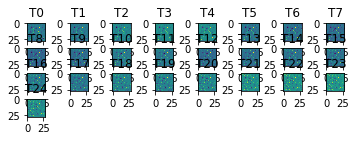

In [9]:
running_loss = 0.0
total_loss_plt = []
for epoch in range(25):  # loop over the dataset multiple times
    
    total_loss = 0
    total_correct = 0
    
    nsamples = 1000

    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        preds = net(inputs) # Pass batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_size
        total_correct += get_num_correct(preds, labels)
        
        net.flex1.memorized_1pixel.append(net.flex1.threshold1.detach().numpy()[1,1,10,10])
        net.flex1.thresh_max.append(torch.max(net.flex1.threshold1))
        net.flex1.thresh_min.append(torch.min(net.flex1.threshold1))
        net.flex1.thresh_mean.append(torch.mean(net.flex1.threshold1))
    
        if i == len(trainloader)-1:
            net.flex1.memorized_1loop = net.flex1.threshold1
            #at the end of every epoch plot threshold
            title = 'T'+str(epoch)
            plt.subplot(8,8, epoch + 1)
            plt.subplots_adjust(hspace=0.4, bottom=0.2)
            plt.title(title)
            #imgplot = plt.imshow(net.flex1.threshold1.detach().numpy()[1,1,:])
            imgplot = plt.imshow(net.flex1.memorized_1loop.detach().numpy()[1,1,:] - memorized.detach().numpy()[1,1,:])
            
    
    # ...log the total epoch accuracy
    # writer.add_scalar('Accuracy', total_correct / len(trainset), epoch)
       
    total_loss_plt.append(total_loss)
        
    print("epoch:", epoch, "loss:", total_loss)
        
print('Finished Training')

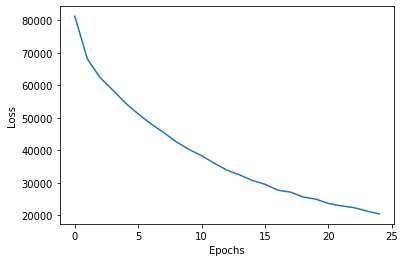

In [10]:
plt.plot(total_loss_plt)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

In [11]:
print('Accuracy is ', total_correct / len(trainset))

Accuracy is  0.85978


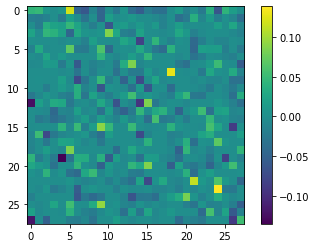

In [12]:
#after training
imgplot = plt.imshow(net.flex1.threshold1.detach().numpy()[1,1,:] - memorized.detach().numpy()[1,1,:])
plt.colorbar()

<Figure size 432x288 with 0 Axes>

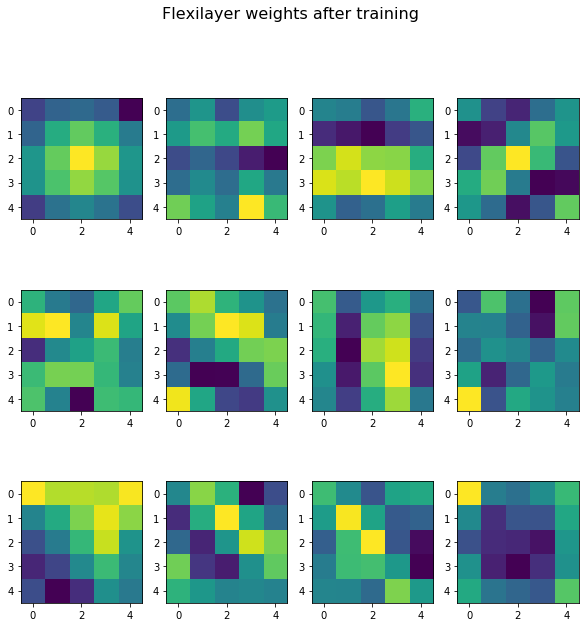

In [13]:
# plot the flex weights after training

fig = plt.figure()
fig = plt.figure(figsize=(10,10))
plt.suptitle('Flexilayer weights after training', fontsize = 16)
for idx, filt  in enumerate(net.flex1.weight.detach().numpy()[:,0,:,:]):
    im = plt.subplot(3,4, idx + 1)
    plt.imshow(net.flex1.weight.detach().numpy()[idx,0,:,:]) # , cmap="gray"
#plt.colorbar()

    
fig.show()

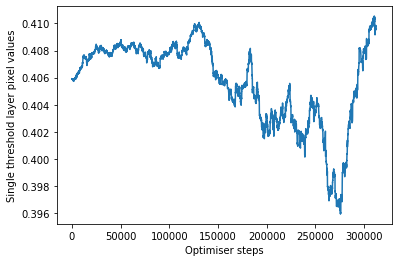

In [14]:
plt.plot(net.flex1.memorized_1pixel)
plt.ylabel('Single threshold layer pixel values')
plt.xlabel('Optimiser steps')
plt.show()

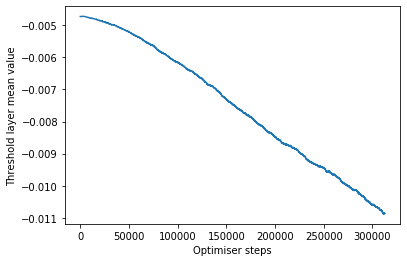

In [15]:
plt.plot(net.flex1.thresh_mean)
plt.ylabel('Threshold layer mean value')
plt.xlabel('Optimiser steps')
plt.show()